In [1]:
import numpy as np
import seaborn

%matplotlib inline
import matplotlib.pyplot as plt

from mab.bandits import (
    make_stationary_bandits,
    non_stationary_bandit_maker,
    run_bandits,
    UPDATE_RULE_MEAN, UPDATE_RULE_CONSTANT,
    BANDIT_CHOICE_RULE_GREEDY, BANDIT_CHOICE_RULE_UCB)

In [2]:
%%timeit
bandits, _ = make_stationary_bandits(n_bandits=10, n_times=10000)
action_estimates, reward_at_stage = run_bandits(bandits)

4.29 ms ± 61.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [3]:
def bootstrap_bandits(n_bandits=10, n_times=10000, n_bootstraps=1000,
                      alpha=0.1,
                      epsilon=0.1,
                      bandit_maker=make_stationary_bandits,
                      update_type=UPDATE_RULE_MEAN,
                      bandit_choice_type=BANDIT_CHOICE_RULE_GREEDY):
    reward_at_stages = np.zeros((n_bootstraps, n_times))
    made_best_choice = np.zeros((n_bootstraps, n_times))
    for i in range(n_bootstraps):
        bandits, bandit_means = bandit_maker(n_bandits, n_times)    
        best_bandit = np.argmax(bandit_means)
        reward_at_stage, choice_at_stage = run_bandits(
            bandits, alpha=alpha, 
            epsilon=epsilon,
            update_type=update_type,
            bandit_choice_type=bandit_choice_type)
        reward_at_stages[i, :] = reward_at_stage
        made_best_choice[i, :] = choice_at_stage == best_bandit
    return np.mean(reward_at_stages, axis=0), np.mean(made_best_choice, axis=0)

## Check Distributions of Bandits

In [4]:
n_bandits = 10
n_times = 1000

bandits, bandit_means = make_stationary_bandits(n_bandits, n_times)
bandits_long = np.zeros((n_bandits * n_times, 2))
bandits_long[:, 0] = bandits.reshape((n_bandits * n_times))
bandits_long[:, 1] = np.repeat(np.arange(10), n_times)

/Users/matthewdrury/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:598: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/Users/matthewdrury/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:826: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


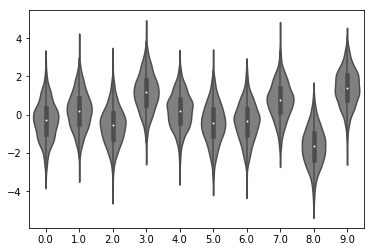

In [5]:
_ = seaborn.violinplot(bandits_long[:, 1], bandits_long[:, 0], color="grey")

## What is the Expected Mean of the Greedy Bandit?

In [6]:
import numpy as np
from scipy.stats import norm
import random

n_bootstraps = 2000
n_bandits = 10

means = []

for i in range(n_bootstraps):
    bandit_means = np.random.normal(size=10)
    bandits = [norm(loc=bandit_mean) for bandit_mean in bandit_means]
    while True:
        b = random.choice(bandits)
        x = b.rvs()
        if x > 0:
            means.append(b.mean())
            break

In [7]:
np.mean(means)

0.5418970175353497

## Stationary Bandits: Sample Mean Update Rule, Greedy Bandit Selection

In [37]:
n_bootstraps = 2000
n_times = 10000

mean_rewards_greedy, correct_choices_greedy = bootstrap_bandits(
    n_bootstraps=n_bootstraps, n_times=n_times, epsilon=0.0)
mean_rewards_e1, correct_choices_e1 = bootstrap_bandits(
    n_bootstraps=n_bootstraps, n_times=n_times, epsilon=0.1)
mean_rewards_e01, correct_choices_e01 = bootstrap_bandits(
    n_bootstraps=n_bootstraps, n_times=n_times, epsilon=0.01)

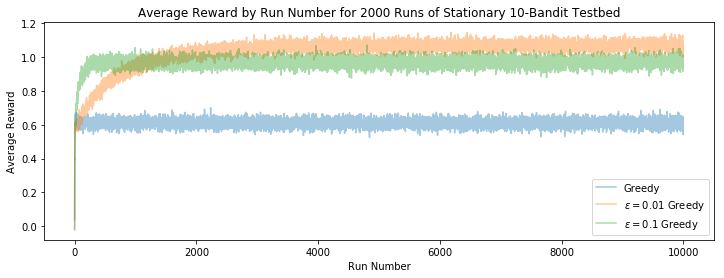

In [38]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(range(n_times), mean_rewards_greedy, alpha=0.4,
        label="Greedy")
ax.plot(range(n_times), mean_rewards_e01, alpha=0.4,
        label="$\epsilon=0.01$ Greedy")
ax.plot(range(n_times), mean_rewards_e1, alpha=0.4,
        label="$\epsilon=0.1$ Greedy")

ax.set_xlabel("Run Number")
ax.set_ylabel("Average Reward")
ax.set_title(f"Average Reward by Run Number for {n_bootstraps} Runs of Stationary 10-Bandit Testbed")
plt.legend()

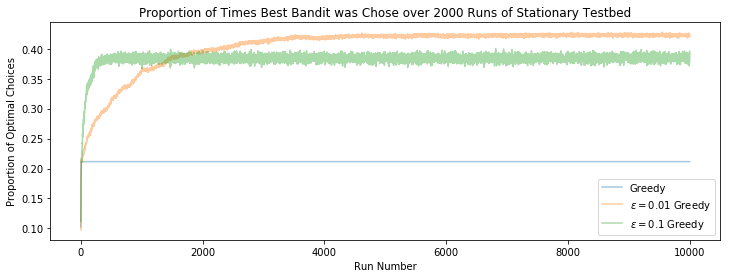

In [39]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(range(n_times), correct_choices_greedy, alpha=0.4,
        label="Greedy")
ax.plot(range(n_times), correct_choices_e01, alpha=0.4,
        label="$\epsilon=0.01$ Greedy")
ax.plot(range(n_times), correct_choices_e1, alpha=0.4,
        label="$\epsilon=0.1$ Greedy")

ax.set_xlabel("Run Number")
ax.set_ylabel("Proportion of Optimal Choices")
ax.set_title(f"Proportion of Times Best Bandit was Chose over {n_bootstraps} Runs of Stationary Testbed")
plt.legend()

## Stationary Bandits: Sample Mean Update Rule, UCB Bandit Selection

In [34]:
n_bootstraps = 2000
n_times = 10000

mean_rewards_greedy, correct_choices_greedy = bootstrap_bandits(
    n_bootstraps=n_bootstraps, n_times=n_times, epsilon=0.0, 
    bandit_choice_type=BANDIT_CHOICE_RULE_UCB)
mean_rewards_e1, correct_choices_e1 = bootstrap_bandits(
    n_bootstraps=n_bootstraps, n_times=n_times, epsilon=0.1,
    bandit_choice_type=BANDIT_CHOICE_RULE_UCB)
mean_rewards_e01, correct_choices_e01 = bootstrap_bandits(
    n_bootstraps=n_bootstraps, n_times=n_times, epsilon=0.01,
    bandit_choice_type=BANDIT_CHOICE_RULE_UCB)

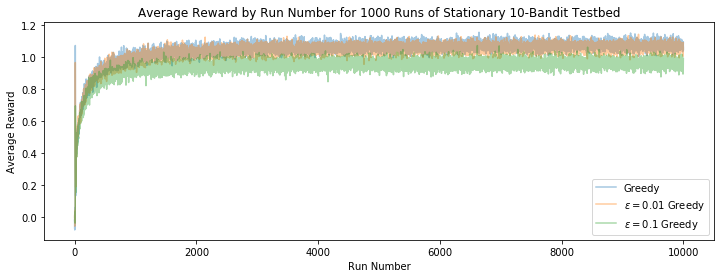

In [35]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(range(n_times), mean_rewards_greedy, alpha=0.4,
        label="Greedy")
ax.plot(range(n_times), mean_rewards_e01, alpha=0.4,
        label="$\epsilon=0.01$ Greedy")
ax.plot(range(n_times), mean_rewards_e1, alpha=0.4,
        label="$\epsilon=0.1$ Greedy")

ax.set_xlabel("Run Number")
ax.set_ylabel("Average Reward")
ax.set_title("Average Reward by Run Number for 1000 Runs of Stationary 10-Bandit Testbed")
plt.legend()

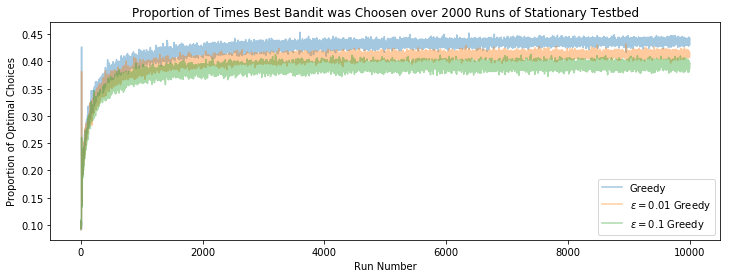

In [36]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(range(n_times), correct_choices_greedy, alpha=0.4,
        label="Greedy")
ax.plot(range(n_times), correct_choices_e01, alpha=0.4,
        label="$\epsilon=0.01$ Greedy")
ax.plot(range(n_times), correct_choices_e1, alpha=0.4,
        label="$\epsilon=0.1$ Greedy")

ax.set_xlabel("Run Number")
ax.set_ylabel("Proportion of Optimal Choices")
ax.set_title(f"Proportion of Times Best Bandit was Choosen over {n_bootstraps} Runs of Stationary Testbed")
plt.legend()

## Stationary Bandits: Constant Update Rule

In [40]:
n_bootstraps = 1000
n_times = 10000


mean_rewards_greedy, correct_choices_greedy = bootstrap_bandits(
                                        n_bootstraps=n_bootstraps,
                                        n_times=n_times,
                                        epsilon=0.0,
                                        update_type=UPDATE_RULE_CONSTANT)
mean_rewards_e1, correct_choices_e1 = bootstrap_bandits(
                                    n_bootstraps=n_bootstraps,
                                    n_times=n_times,
                                    epsilon=0.1,
                                    update_type=UPDATE_RULE_CONSTANT)
mean_rewards_e01, correct_choices_e01 = bootstrap_bandits(
                                     n_bootstraps=n_bootstraps,
                                     n_times=n_times,
                                     epsilon=0.01,
                                     update_type=UPDATE_RULE_CONSTANT)

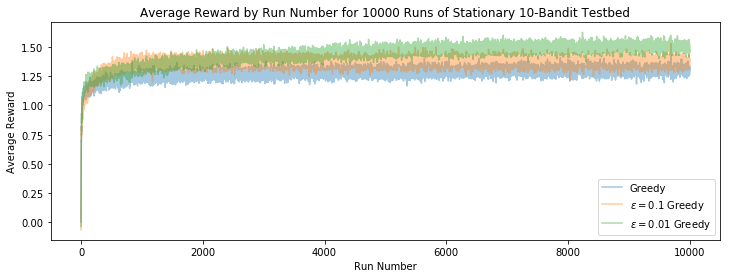

In [41]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(range(n_times), mean_rewards_greedy, alpha=0.4,
        label="Greedy")
ax.plot(range(n_times), mean_rewards_e1, alpha=0.4,
        label="$\epsilon=0.1$ Greedy")
ax.plot(range(n_times), mean_rewards_e01, alpha=0.4,
        label="$\epsilon=0.01$ Greedy")

ax.set_xlabel("Run Number")
ax.set_ylabel("Average Reward")
ax.set_title(f"Average Reward by Run Number for {n_times} Runs of Stationary 10-Bandit Testbed")
plt.legend()

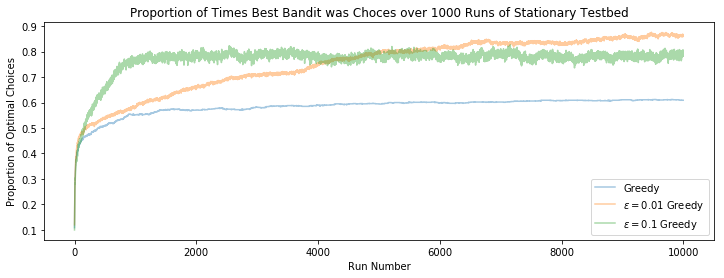

In [42]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(range(n_times), correct_choices_greedy, alpha=0.4,
        label="Greedy")
ax.plot(range(n_times), correct_choices_e01, alpha=0.4,
        label="$\epsilon=0.01$ Greedy")
ax.plot(range(n_times), correct_choices_e1, alpha=0.4,
        label="$\epsilon=0.1$ Greedy")

ax.set_xlabel("Run Number")
ax.set_ylabel("Proportion of Optimal Choices")
ax.set_title(f"Proportion of Times Best Bandit was Choces over {n_bootstraps} Runs of Stationary Testbed")
plt.legend()

## Non-Stationary Bandits: Sample Mean Updating

In [43]:
drifts = [0.01, 0.05, 0.1]
n_bootstraps = 1000
n_times = 10000

mean_rewards_greedy = {
    drift: bootstrap_bandits(
        n_bootstraps=n_bootstraps, 
        n_times=n_times,
        alpha=0.1,
        epsilon=0.0, 
        bandit_maker=non_stationary_bandit_maker(drift=drift))
    for drift in drifts}
mean_rewards_e1 = {drift: 
    bootstrap_bandits(
        n_bootstraps=n_bootstraps,
        n_times=n_times,
        alpha=0.1,
        epsilon=0.1, 
        bandit_maker=non_stationary_bandit_maker(drift=drift))
    for drift in drifts}
mean_rewards_e01 = {
    drift: bootstrap_bandits(
        n_bootstraps=n_bootstraps,
        n_times=n_times,
        alpha=0.1,
        epsilon=0.01, 
        bandit_maker=non_stationary_bandit_maker(drift=drift))
    for drift in drifts}

ValueError: too many values to unpack (expected 2)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

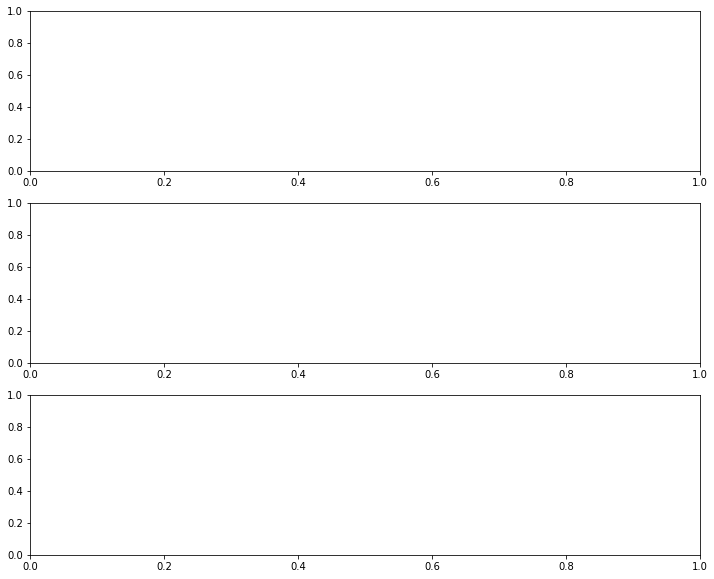

In [44]:
fig, axs = plt.subplots(3, figsize=(12, 10))

for i, (drift, ax) in enumerate(zip(drifts, axs.flatten())):
    ax.plot(range(n_times), mean_rewards_greedy[drift], alpha=0.4,
            label="Greedy")
    ax.plot(range(n_times), mean_rewards_e1[drift], alpha=0.4,
            label="$\epsilon=0.1$ Greedy")
    ax.plot(range(n_times), mean_rewards_e01[drift], alpha=0.4,
            label="$\epsilon=0.01$ Greedy")
    if i == 2:
        ax.set_xlabel("Run Number")
    ax.set_ylabel("Average Reward")
    ax.set_title(f"Average Reward by Run Number for 1000 Runs of Non-Stationary Bandits. Drift = {drift}")
    ax.legend(loc="upper left")
fig.tight_layout()

## Non-Stationary Bandits: Constant Step Size Updates

In [12]:
drifts = [0.01, 0.05, 0.1]
n_bootstraps = 1000
n_times = 10000

mean_rewards_greedy = {drift: bootstrap_bandits(
                           n_bootstraps=n_bootstraps, 
                           n_times=n_times,
                           epsilon=0.0, 
                           bandit_maker=non_stationary_bandit_maker(drift=drift),
                           update_type=UPDATE_RULE_CONSTANT)
                       for drift in drifts}
mean_rewards_e1 = {drift: bootstrap_bandits(
                       n_bootstraps=n_bootstraps,
                       n_times=n_times,
                       epsilon=0.1, 
                       bandit_maker=non_stationary_bandit_maker(drift=drift),
                       update_type=UPDATE_RULE_CONSTANT)
                   for drift in drifts}
mean_rewards_e01 = {drift: bootstrap_bandits(
                        n_bootstraps=n_bootstraps,
                        n_times=n_times,
                        epsilon=0.01, 
                        bandit_maker=non_stationary_bandit_maker(drift=drift),
                        update_type=UPDATE_RULE_CONSTANT)
                   for drift in drifts}

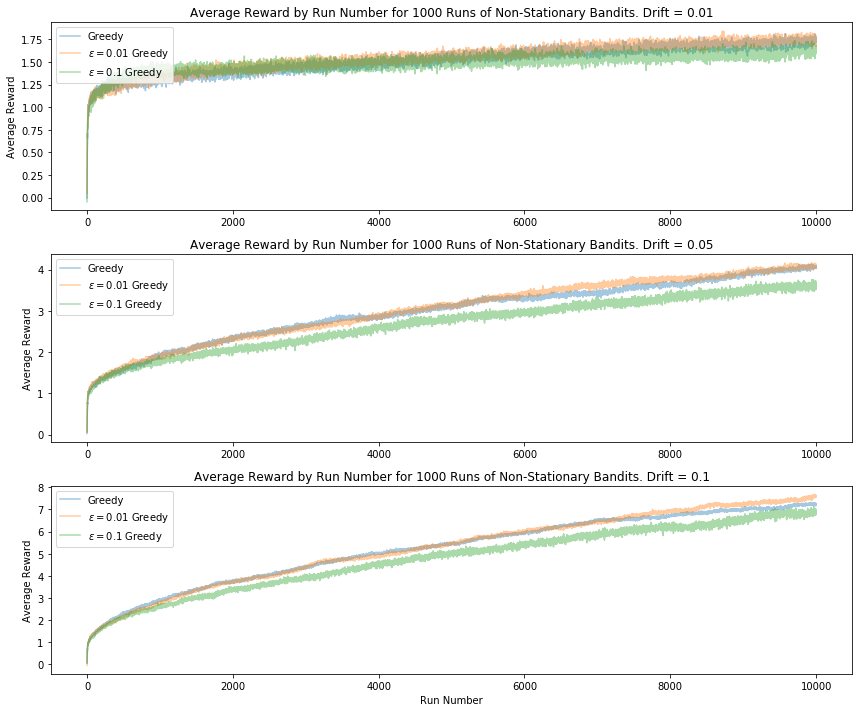

In [13]:
fig, axs = plt.subplots(3, figsize=(12, 10))

for i, (drift, ax) in enumerate(zip(drifts, axs.flatten())):
    ax.plot(range(n_times), mean_rewards_greedy[drift], alpha=0.4,
            label="Greedy")
    ax.plot(range(n_times), mean_rewards_e01[drift], alpha=0.4,
            label="$\epsilon=0.01$ Greedy")
    ax.plot(range(n_times), mean_rewards_e1[drift], alpha=0.4,
            label="$\epsilon=0.1$ Greedy")
    if i == 2:
        ax.set_xlabel("Run Number")
    ax.set_ylabel("Average Reward")
    ax.set_title(f"Average Reward by Run Number for 1000 Runs of Non-Stationary Bandits. Drift = {drift}")
    ax.legend(loc="upper left")
fig.tight_layout()